In [2]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from lightning.pytorch.tuner import Tuner
import torch
from pytorch_forecasting.metrics import MAE
import pandas as pd

In [3]:
Final_DataFrame = pd.read_csv('Out_120.csv')

In [4]:
Final_DataFrame['id'] = "BTC"

In [7]:
Final_DataFrame.dtypes

Unnamed: 0                int64
Date             datetime64[ns]
BTC_Price               float64
BTC_Volume              float64
Gold_Price              float64
Interest_Rate           float64
VIX_Close               float64
id                       object
dtype: object

In [6]:
Final_DataFrame['Date'] = pd.to_datetime(Final_DataFrame['Date'])

In [8]:
# add additional features
import numpy as np


Final_DataFrame["month"] = Final_DataFrame.Date.dt.month.astype(str).astype("category")  # categories have be strings
Final_DataFrame["day_of_week"] = Final_DataFrame.Date.dt.dayofweek.astype(str).astype("category")
Final_DataFrame["day_of_year"] = Final_DataFrame.Date.dt.dayofyear.astype(str).astype("category")
Final_DataFrame["quarter"] = Final_DataFrame.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

Final_DataFrame["log_price"] = np.log(Final_DataFrame.BTC_Price + 1e-8)

In [14]:
Final_DataFrame.head(10)

,Unnamed: 0,Date,BTC_Price,BTC_Volume,Gold_Price,Interest_Rate,VIX_Close,id,month,day_of_week,day_of_year,quarter,log_price,time_idx
0,0,2019-08-28,0.070231,0.035507,0.079985,0.393195,0.109768,BTC,8,2,240,3,-2.655965,0
1,1,2019-08-29,0.066646,0.033893,0.071482,0.393195,0.089108,BTC,8,3,241,3,-2.708360,1
2,2,2019-08-30,0.067937,0.023910,0.064474,0.395085,0.104568,BTC,8,4,242,3,-2.689174,2
3,3,2019-08-31,0.068414,0.017717,0.064474,0.395085,0.104568,BTC,8,5,243,3,-2.682178,3
4,4,2019-09-01,0.070283,0.017690,0.064474,0.395085,0.104568,BTC,9,6,244,3,-2.655225,4
5,5,2019-09-02,0.078928,0.034478,0.092226,0.395085,0.104568,BTC,9,0,245,3,-2.539219,5
6,6,2019-09-03,0.082991,0.040660,0.089329,0.395085,0.114125,BTC,9,1,246,3,-2.489023,6
7,7,2019-09-04,0.082565,0.033016,0.093440,0.395085,0.081377,BTC,9,2,247,3,-2.494169,7
8,8,2019-09-05,0.082286,0.026676,0.061017,0.395085,0.066479,BTC,9,3,248,3,-2.497554,8
9,9,2019-09-06,0.079024,0.041099,0.051579,0.393195,0.048630,BTC,9,4,249,3,-2.538004,9


In [10]:
# Define dataset parameters
Final_DataFrame['time_idx'] = Final_DataFrame.index

In [11]:
max_prediction_length = 30  # Set to desired prediction length
max_encoder_length = 90  # Set to desired history length (e.g., 30 days) - pass 30 days are used to predict next 7 days
batch_size = 64
training_cutoff = Final_DataFrame['time_idx'].max() - max_prediction_length

In [17]:
training = TimeSeriesDataSet(
    Final_DataFrame[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="BTC_Price",
    group_ids=["id"],  # Use "id" as the group identifier
    max_encoder_length=max_encoder_length // 2,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id"],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    static_reals=[],  # Add any static features if available
    time_varying_known_reals=["time_idx", "BTC_Volume", "Gold_Price", "Interest_Rate", "VIX_Close"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["BTC_Price", "log_price"],
    target_normalizer=GroupNormalizer(groups=["id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [18]:
validation = TimeSeriesDataSet.from_dataset(training, Final_DataFrame, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

In [19]:
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [20]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.003,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 103.5k


c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minim

You are using a CUDA device ('NVIDIA GeForce RTX 2050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connec

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:836: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0034124769651644265
Restoring states from the checkpoint path at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_940094a5-5919-4680-a6d6-2c8a764728c8.ckpt
Restored all states from the checkpoint at c:\Users\Sathmika\Desktop\FYP\cryptoCurrencyPricePredictionTFT\cryptoCurrencyPricePredictionTFT\final\.lr_find_940094a5-5919-4680-a6d6-2c8a764728c8.ckpt


suggested learning rate: 0.0034124769651644265


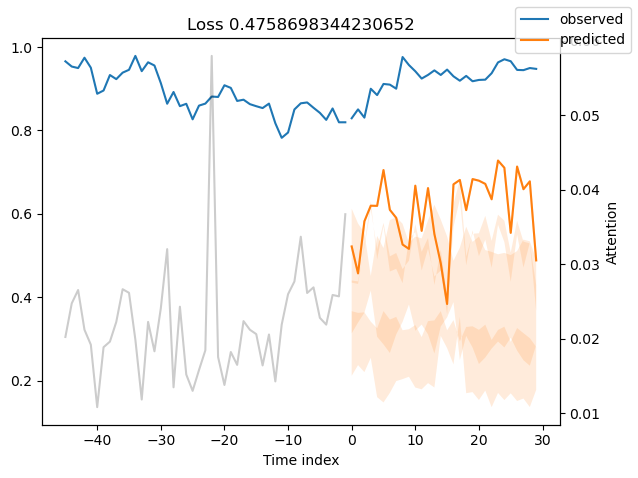

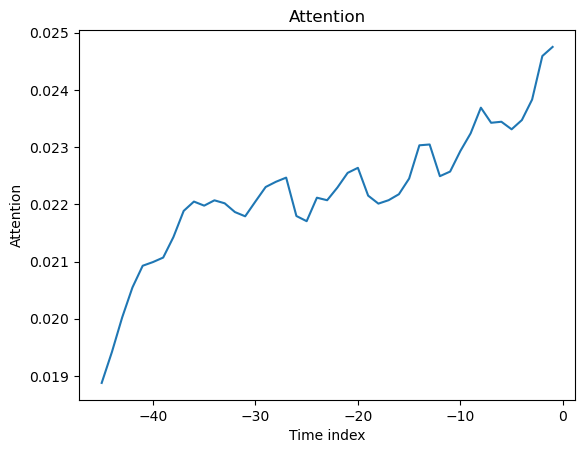

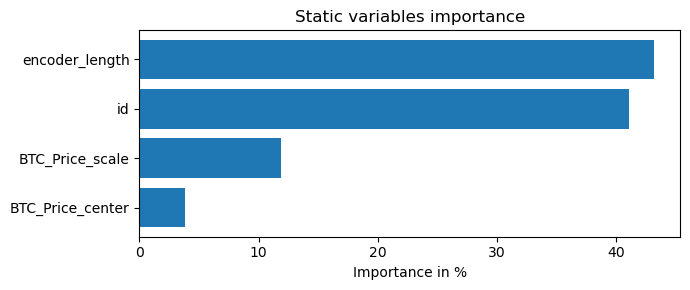

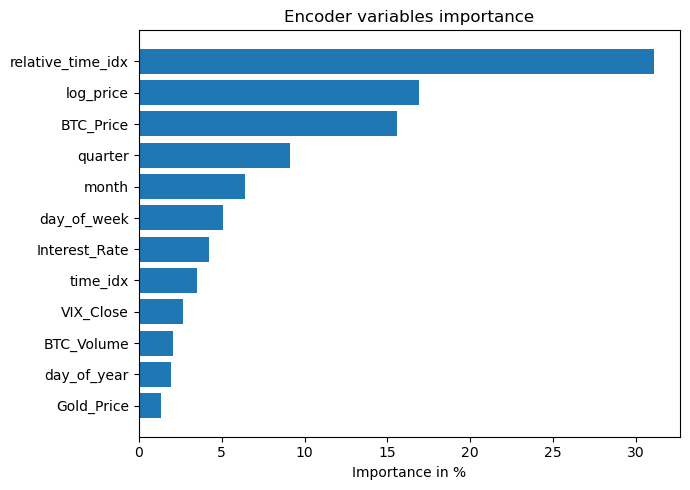

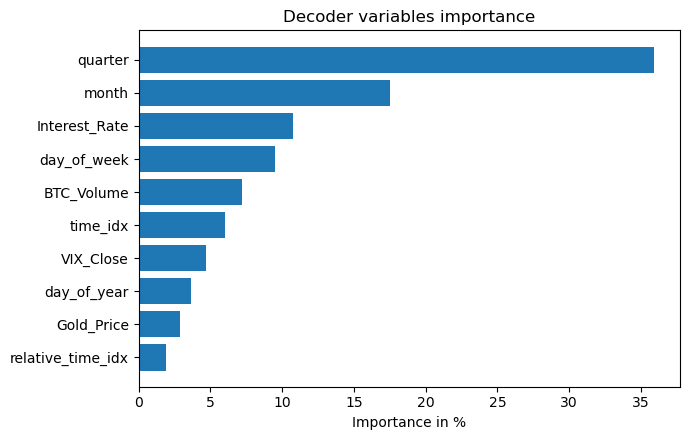

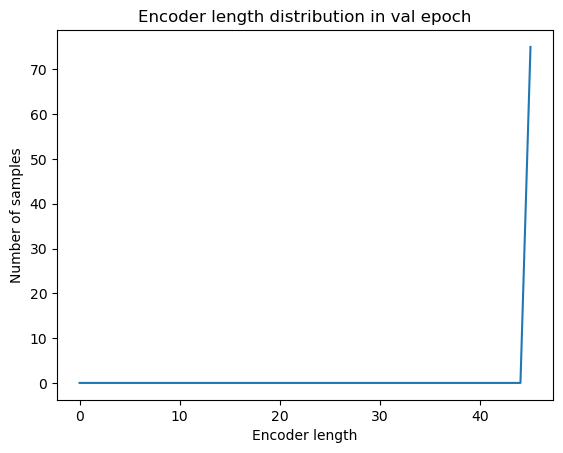

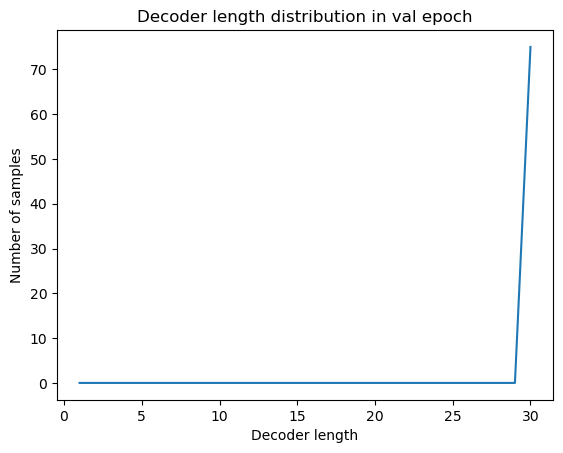

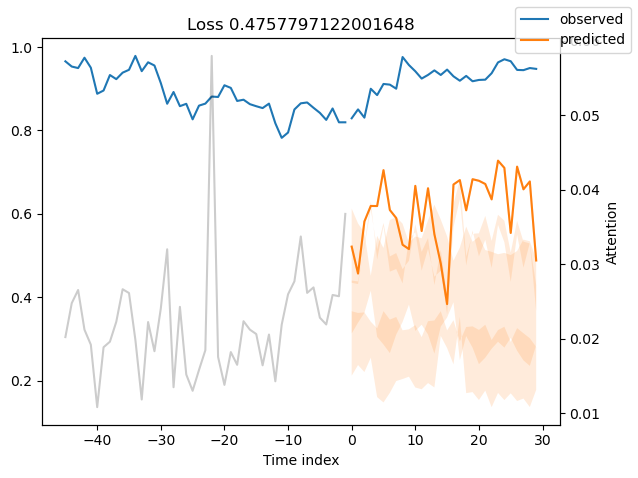

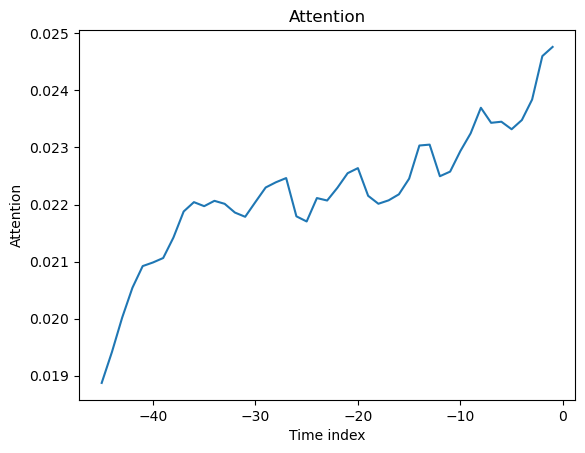

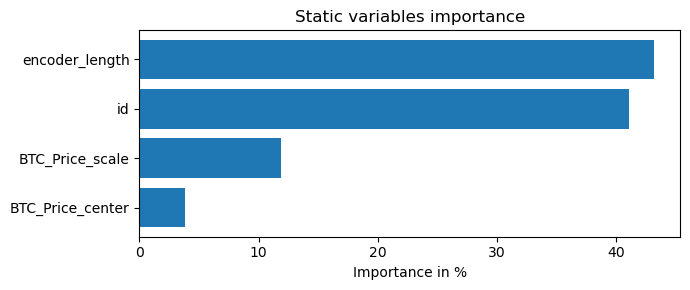

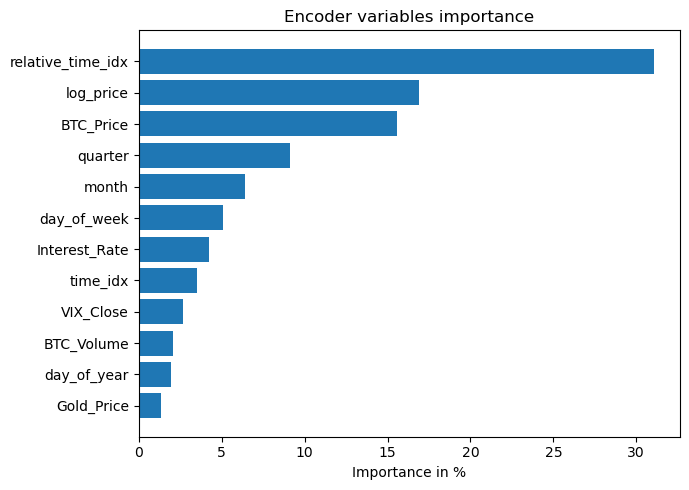

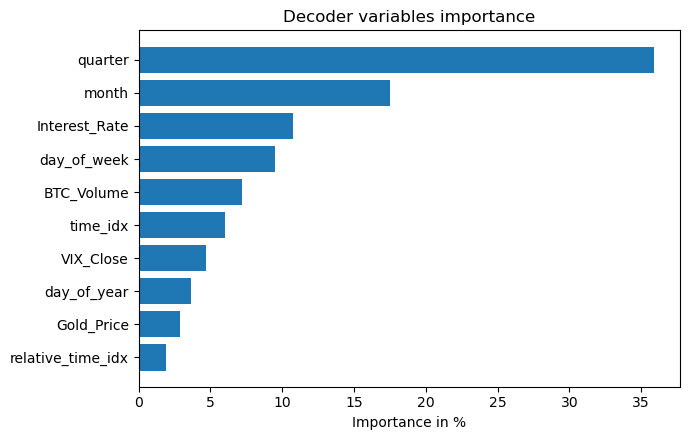

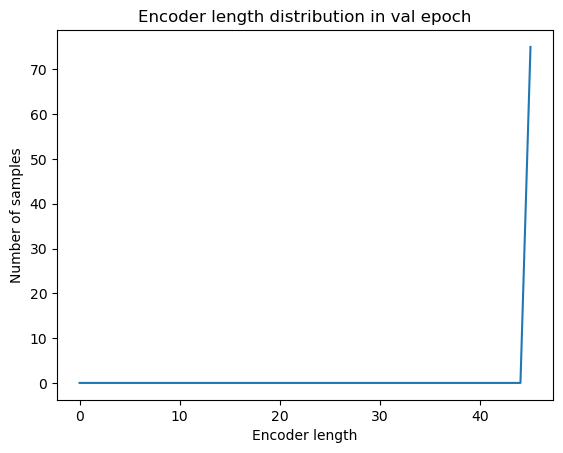

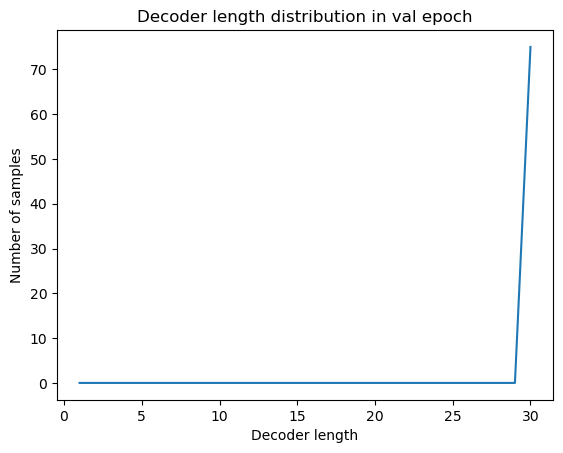

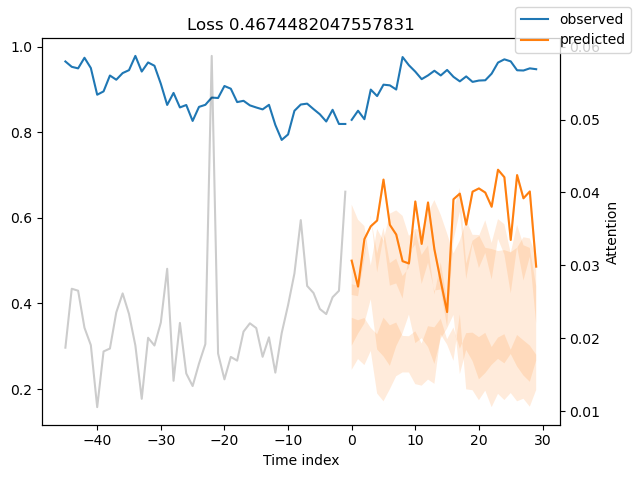

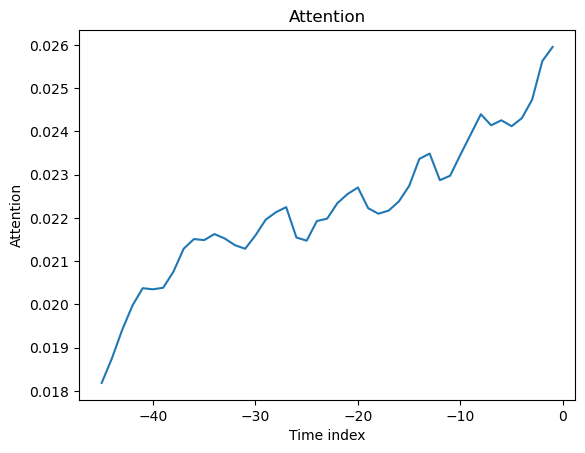

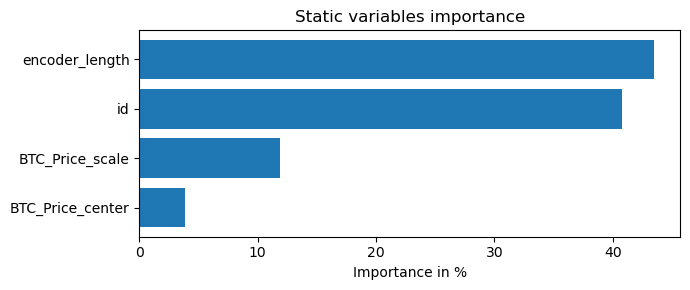

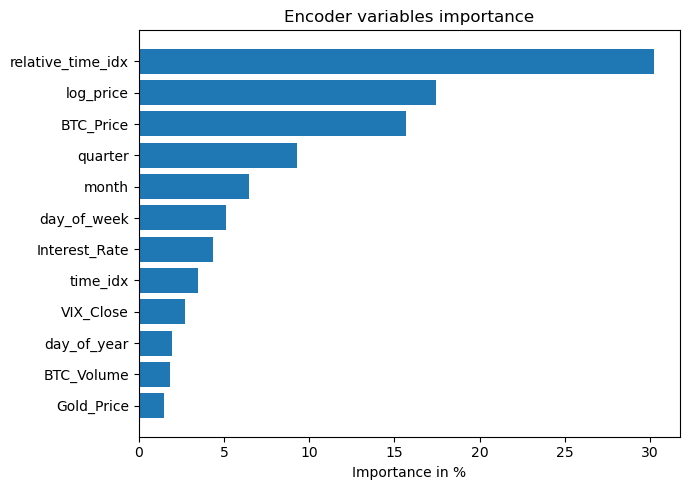

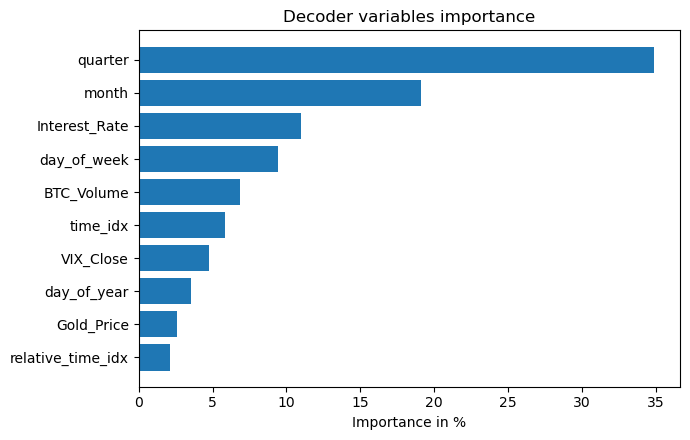

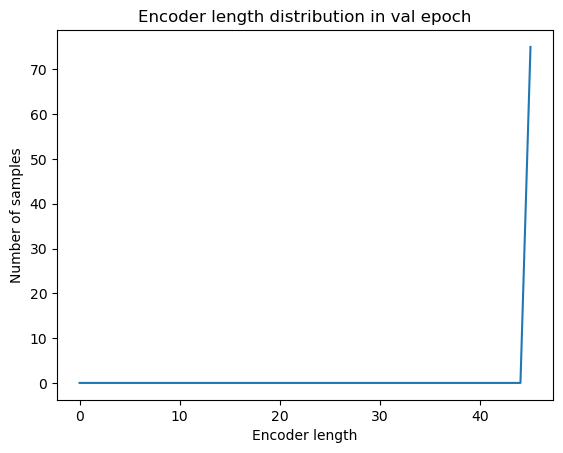

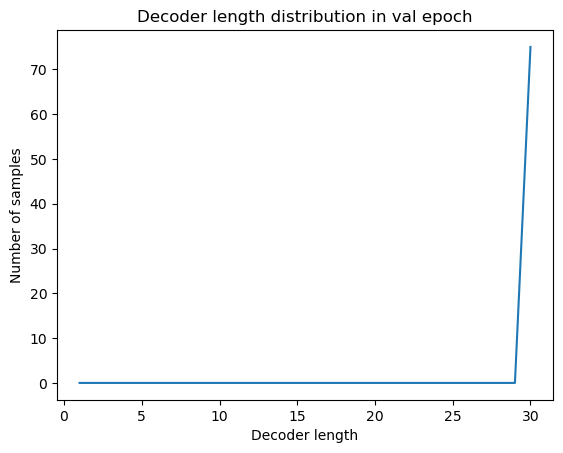

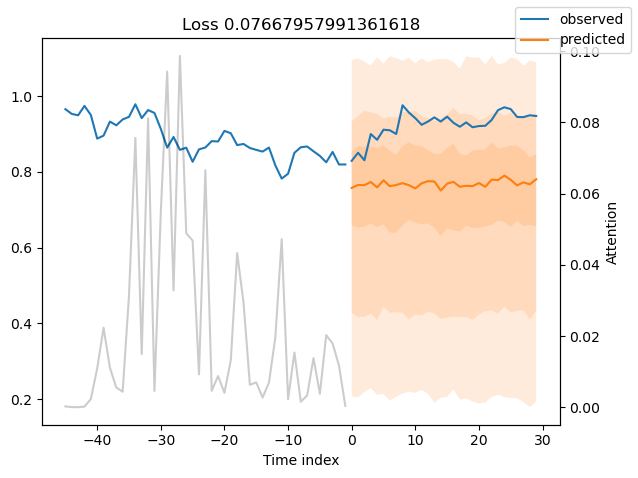

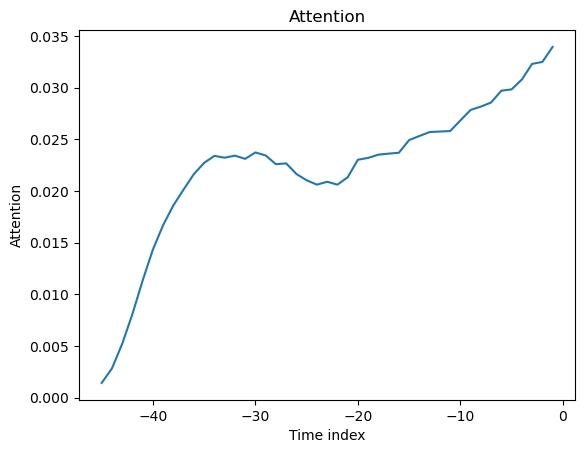

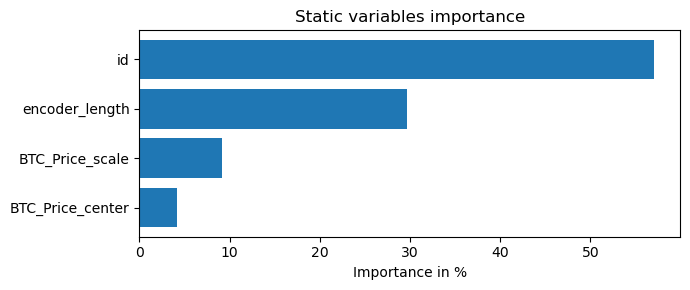

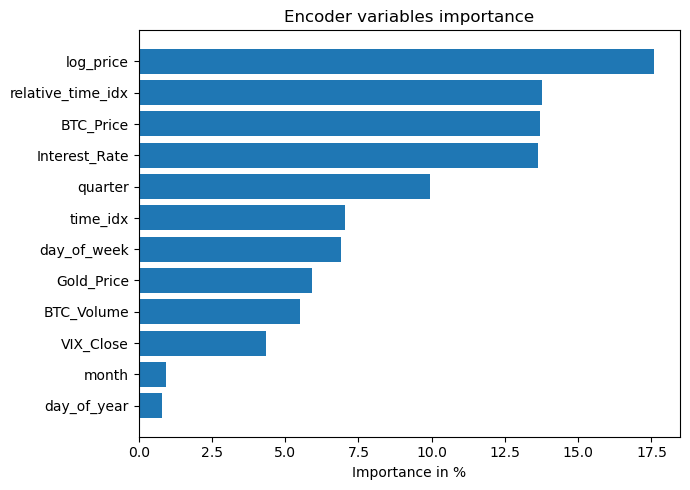

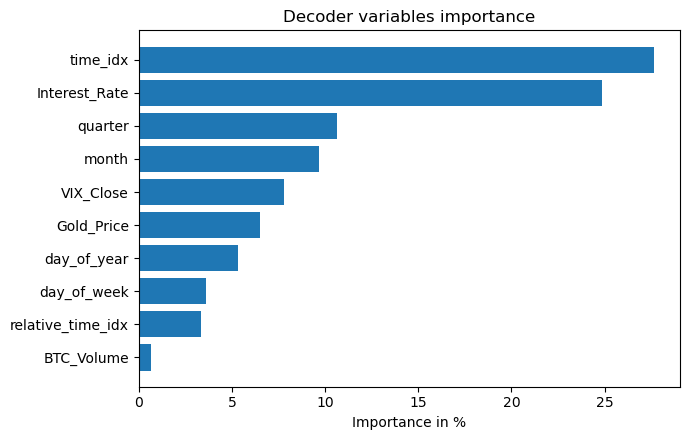

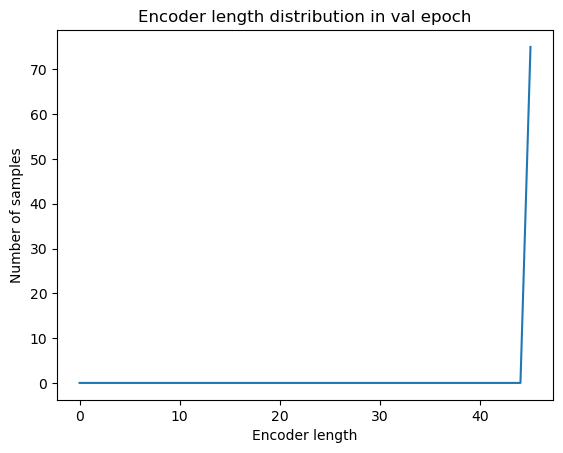

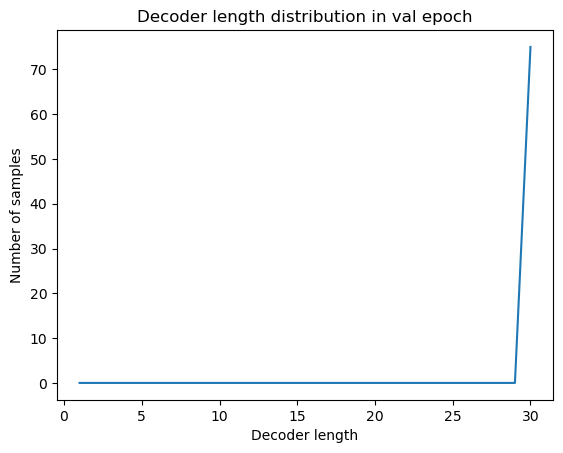

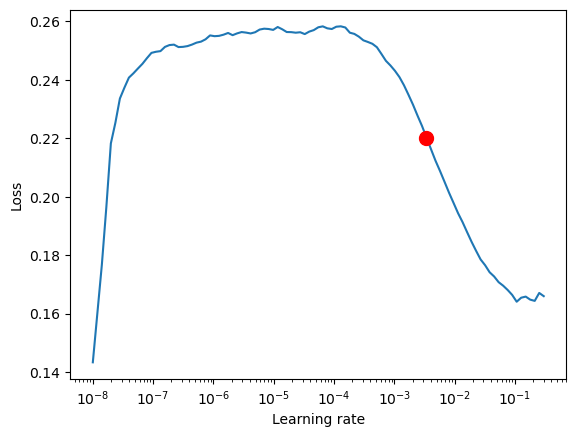

C:\Users\Sathmika\AppData\Local\Temp\ipykernel_11892\1371792773.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [22]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [24]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 11.8 K | train
3  | prescalers                         | ModuleDict                      | 352    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 13.5 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [25]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [27]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


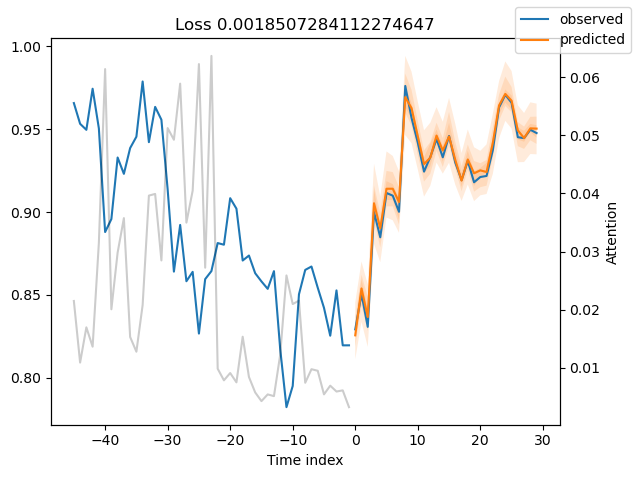

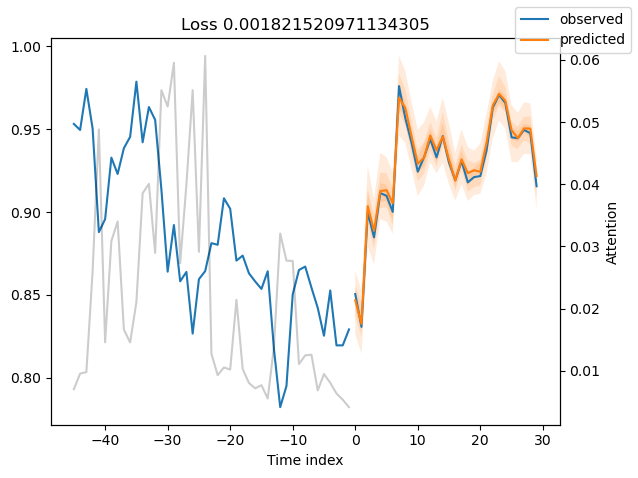

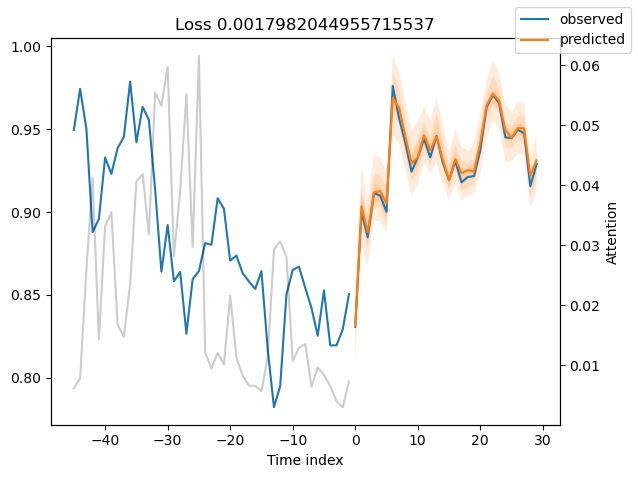

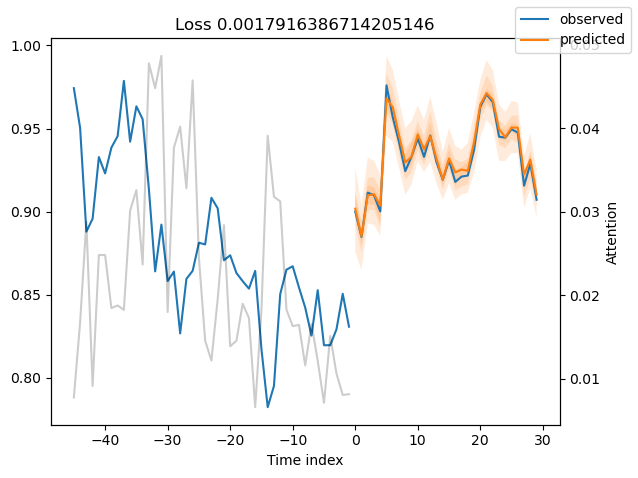

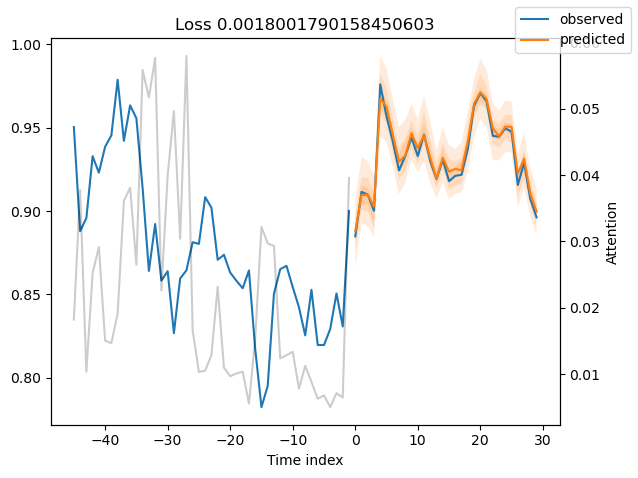

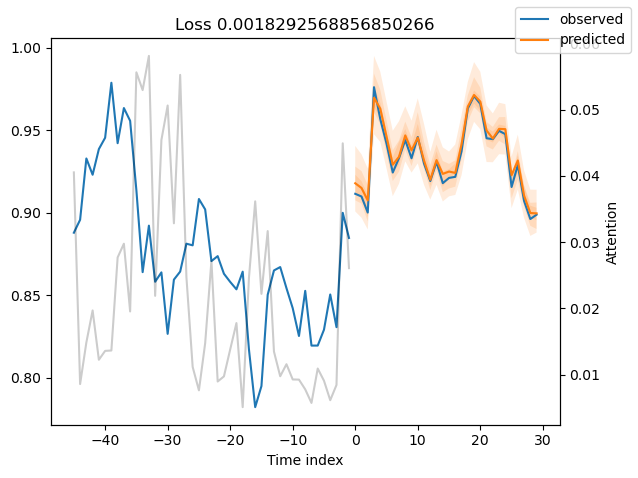

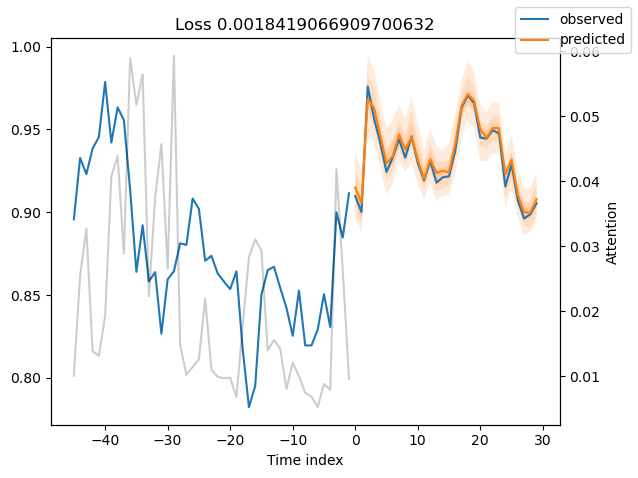

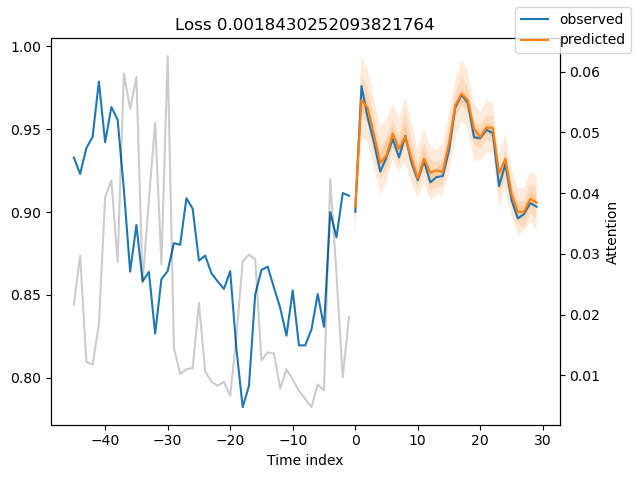

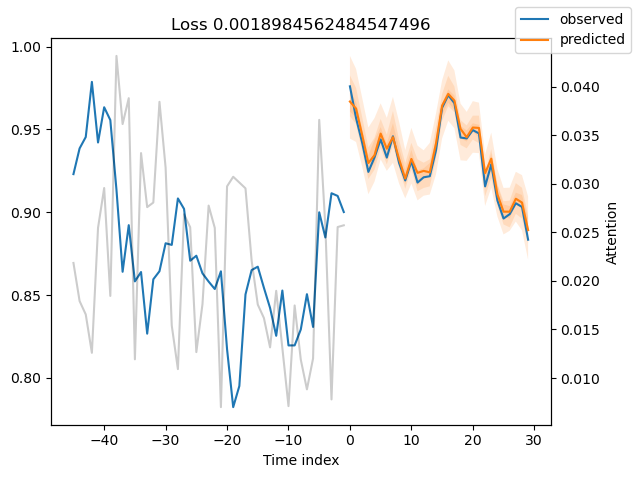

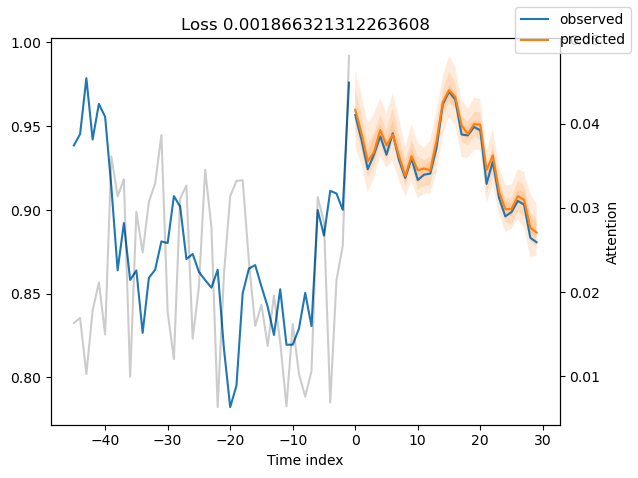

In [28]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [29]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 0.01550800260156393


In [30]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


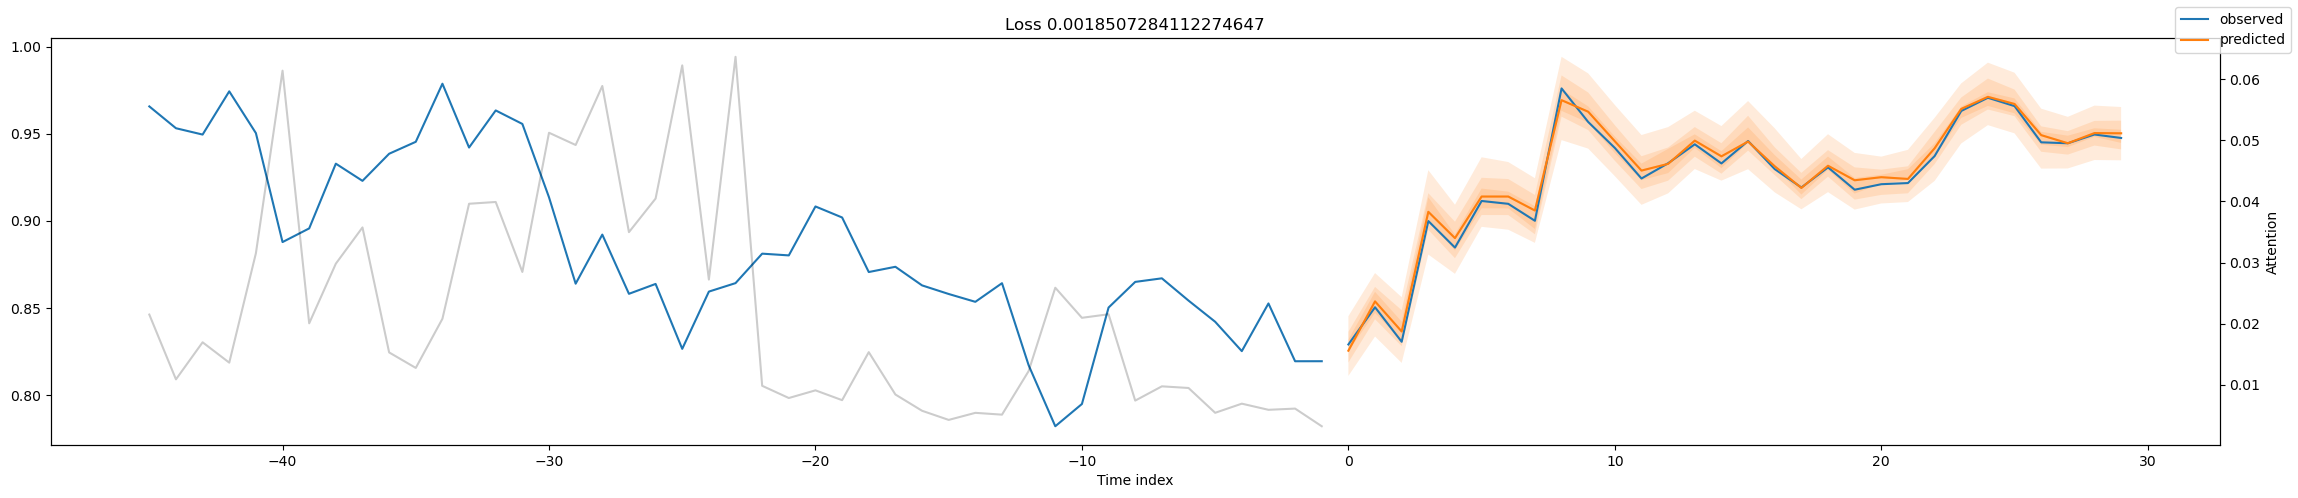

In [32]:
import matplotlib.pyplot as plt

# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

In [34]:
import torch

# Save only the model's state_dict (weights)
torch.save(best_tft.state_dict(), "tft_model_weights.pth")


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x450 with 1 Axes>}

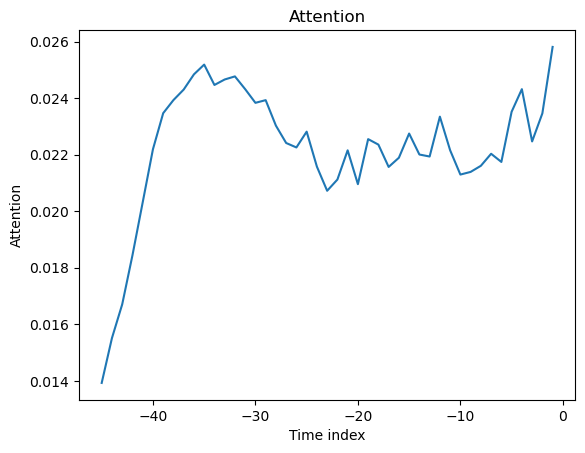

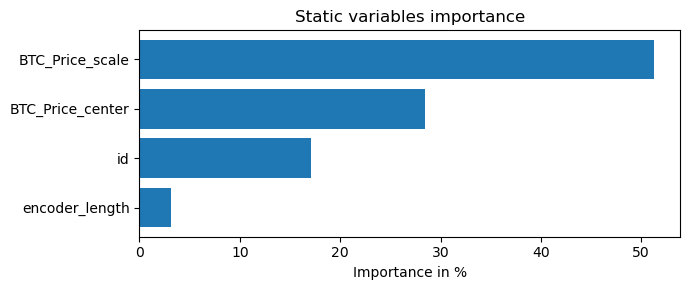

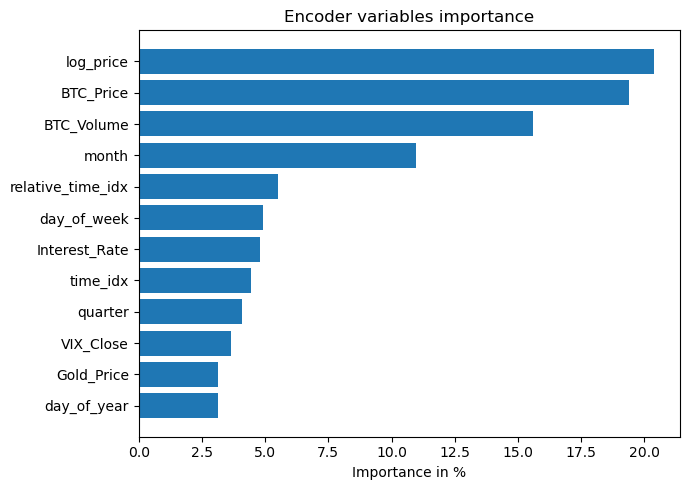

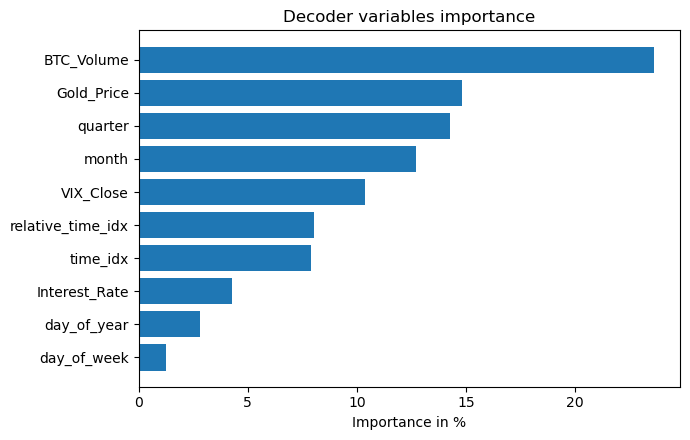

In [39]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)